Part 2 - Q4 - Fine Tuning Strategies
===



# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

2024-05-20 21:21:46.221422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 21:21:47.793921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 21:21:52.413431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
format_dict = par.create_format_dict()

In [7]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

## ML Preliminaries

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tensorflow.keras.models import load_model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.optimizers import Adam

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        
        return K.mean(fl)
    return focal_loss_fixed

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# Import Data

In [8]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [9]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_heart_train.shape

(11641, 188)

## Labels

In [11]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
n_classes = len(labels_count.columns)
labels_count.style.format(format_dict)

,1.0,0.0
proportion,72%,28%


In [18]:
n_classes

2

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


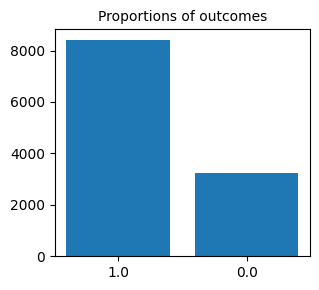

In [12]:
gr.dist_mult_plots(
    df_heart_train,
    cols=[label_col],
		rename_cols_for_title={label_col: 'Proportions of outcomes'},
    figsize=(6, 3),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
)

## Features pre-processing

In [220]:
x_train_0, x_test_0, y_train_0, y_test_0 = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
)

In [221]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

# Question 1: Classic ML Models

## A/ Encoder from the question 1

In [107]:
n_neurons = 40
num_samples = x_train_0.shape[0]
seq_length = x_train_0.shape[1]
input_dim = 1
num_classes = n_classes

In [111]:
num_samples

11641

In [167]:
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [115]:
from tensorflow.keras.models import load_model

# Load the pre-trained encoder
encoder_model_question_1 = load_model('model_log_v2.keras', custom_objects={'focal_loss_fixed': focal_loss})

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
for layer in encoder_model_question_1.layers:
    layer.trainable = False

In [150]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
new_model_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	new_model_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	new_model_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
new_model_from_enc_1.summary()

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,562 (138.91 KB)

 Trainable params: 82 (328.00 B)

 Non-trainable params: 35,480 (138.59 KB)

In [159]:
# Training
# x_train_0_reshaped = x_train_0.reshape(num_samples, seq_length, 1)

history = new_model_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*4,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6027 - loss: 0.1394 - val_accuracy: 0.6196 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 2/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5998 - loss: 0.1241 - val_accuracy: 0.6410 - val_loss: 0.1016 - learning_rate: 0.0010
Epoch 3/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6205 - loss: 0.1141 - val_accuracy: 0.6368 - val_loss: 0.0942 - learning_rate: 0.0010
Epoch 4/8
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6284 - loss: 0.1064
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6285 - loss: 0.1064 - val_accuracy: 0.6402 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 5/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6391 - loss: 0.0986 - val_accuracy: 0.6295 - val_loss: 0.0863 - learning_rate: 3.0000e-04
Epoch 6/8
66/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6379 - loss: 0.0993
Epoch 6: ReduceLROn

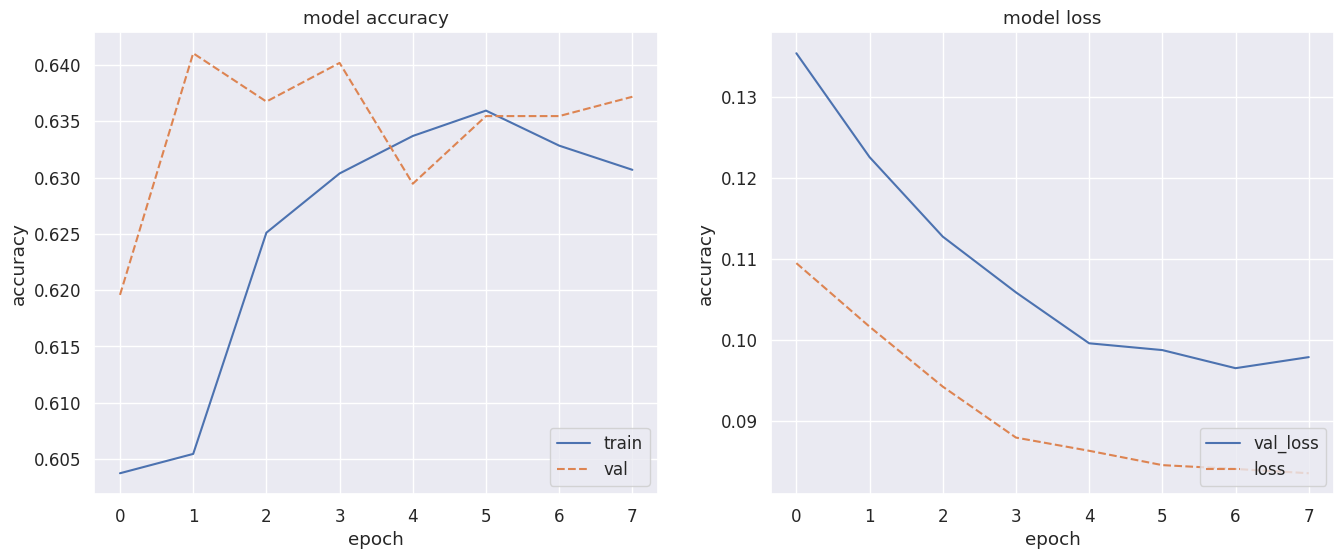

In [160]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

### Evaluation

In [161]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

In [162]:
y_pred_proba = new_model_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [163]:
y_pred_class_df.value_counts()

1    2325
0     586
Name: count, dtype: int64

In [164]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [165]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,65.3%,52.5%,52.3%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

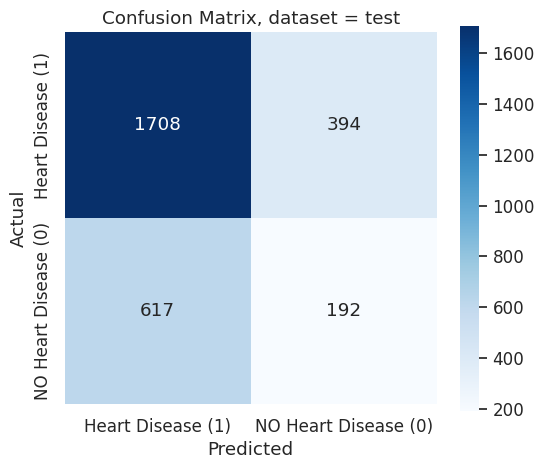

In [166]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [133]:
# # equivalent to: model.save("model.h5")
# from tensorflow.keras.models import save_model
# # save_model(model, "model_second_save.h5")
# # save model and architecture to single file
# model_log.save("model_log.h5")
# model_log.save('model_log.keras')
# print("Saved model to disk")

## B/ Encoder from question 2


In [ ]:
# Load the pre-trained encoder
encoder_model_question_2 = load_model('encoder_2.keras')

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [ ]:
for layer in encoder_model.layers:
    layer.trainable = False

In [ ]:
# Define the input for the new model
new_inputs = encoder_model_question_2.input[0]

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_question_2.output[0]
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
new_model_enc_2 = Model(inputs=new_inputs, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	new_model_enc_2.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	new_model_enc_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
new_model_enc_2.summary()

Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 185, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 90, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_19     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 40)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,202 (117.98 KB)

 Trainable params: 82 (328.00 B)

 Non-trainable params: 30,120 (117.66 KB)

In [ ]:
lib.custom_model_summary(new_model_enc_2)

Model: "functional_101"
Layer (type)                           Param #          Trainable
input_layer_51                      0                     False
conv1d_38                           256                   False
max_pooling1d_19                    0                     False
conv1d_39                           24704                 False
global_average_pooling1d_19         0                     False
dense_31                            5160                  False
dense_17                            82                    True
Total params: 30202
Trainable params: 82
Non-trainable params: 30120


In [ ]:
# Training
x_train_0_reshaped = x_train_0.reshape(num_samples, seq_length, 1)

history = new_model_enc_2.fit(
	x_train_0_reshaped,
	y_train_0,
	batch_size=batch_size*8,
	epochs=6,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6022 - loss: 0.0853 - val_accuracy: 0.7153 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 2/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7254 - loss: 0.0807 - val_accuracy: 0.7162 - val_loss: 0.0783 - learning_rate: 0.0010
Epoch 3/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7265 - loss: 0.0774 - val_accuracy: 0.7162 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 4/6
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7131 - loss: 0.0758
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7136 - loss: 0.0757 - val_accuracy: 0.7162 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 5/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7179 - loss: 0.0743 - val_accuracy: 0.7162 - val_loss: 0.0741 - learning_rate: 3.0000e-04
Epoch 6/6
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7213 - loss: 0.0736
Epoch 6: Red

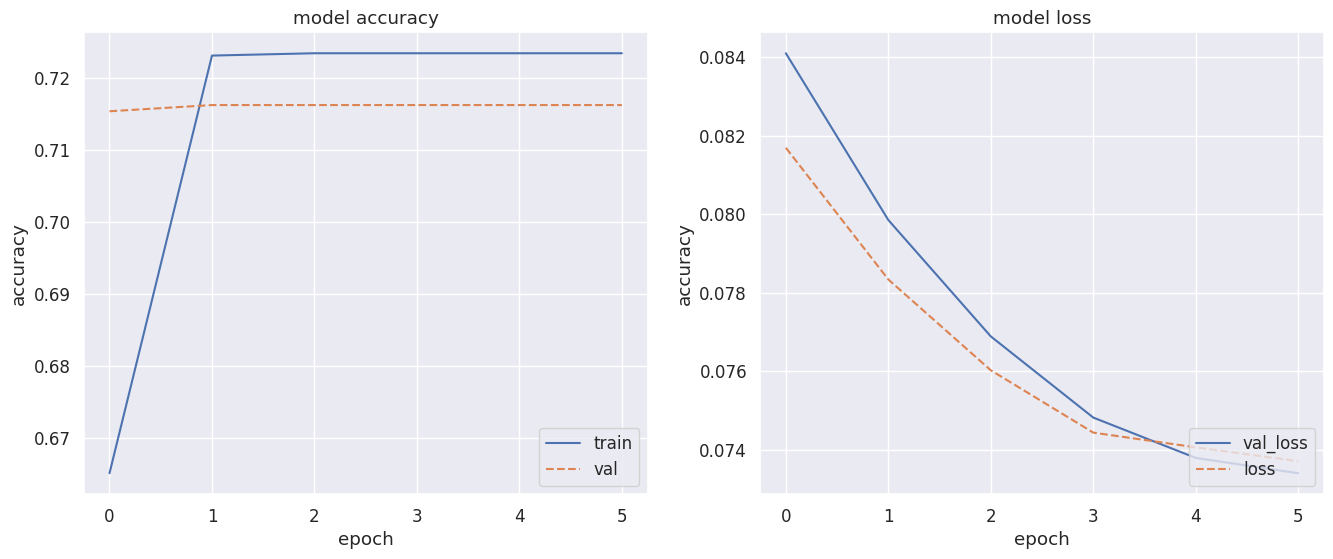

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

### Evaluation

In [ ]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

In [ ]:
y_pred_proba = new_model_enc_2.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2911
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,72.2%,50.0%,41.9%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

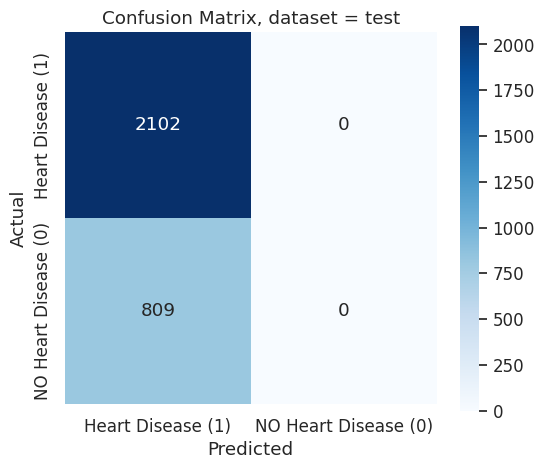

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

# Question 2 + ENCODER QUESTION 1: MLP Output layer

### A/ Train the output layer(s) only

In [228]:
for layer in encoder_model_question_1.layers:
    layer.trainable = False

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [194]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [229]:
# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
MLP_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	MLP_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	MLP_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
MLP_from_enc_1.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 4,770 (18.63 KB)

 Non-trainable params: 35,480 (138.59 KB)

In [230]:
lib.custom_model_summary(MLP_from_enc_1)

Model: "functional_117"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     False
dense_33                            22560                 False
dropout_12                          0                     False
dense_34                            9680                  False
dropout_13                          0                     False
dense_35                            3240                  False
dense_27                            2624                  True
dense_28                            2080                  True
dense_29                            66                    True
Total params: 40250
Trainable params: 4770
Non-trainable params: 35480


In [212]:
# Training
history = MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=20,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7646 - loss: 0.0598 - val_accuracy: 0.7930 - val_loss: 0.0573 - learning_rate: 2.7000e-05
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7630 - loss: 0.0601 - val_accuracy: 0.7939 - val_loss: 0.0573 - learning_rate: 2.7000e-05
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7655 - loss: 0.0602 - val_accuracy: 0.7909 - val_loss: 0.0572 - learning_rate: 2.7000e-05
Epoch 4/20
139/146 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7643 - loss: 0.0592
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7644 - loss: 0.0592 - val_accuracy: 0.7896 - val_loss: 0.0572 - learning_rate: 2.7000e-05
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7628 - loss: 0.0595 - val_accuracy: 0.7965 - val_loss: 0.0573 - learning_rate: 8.1000e-06
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.774

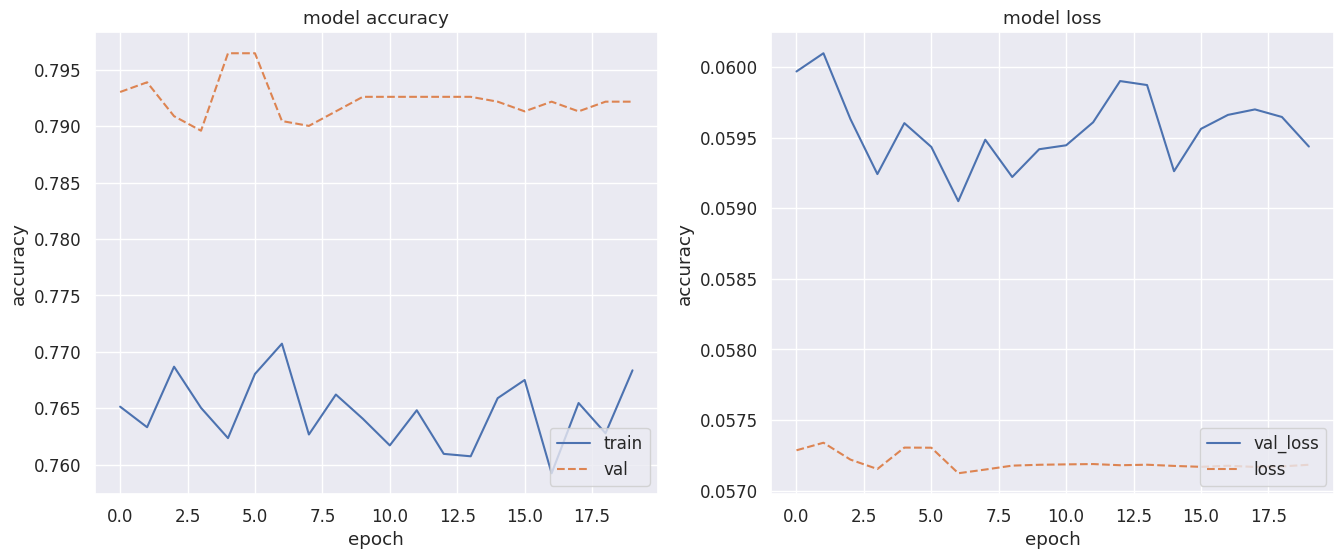

In [213]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [215]:
y_pred_proba = MLP_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [216]:
y_pred_class_df.value_counts()

1    2403
0     508
Name: count, dtype: int64

In [217]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [218]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,78.6%,67.6%,69.4%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

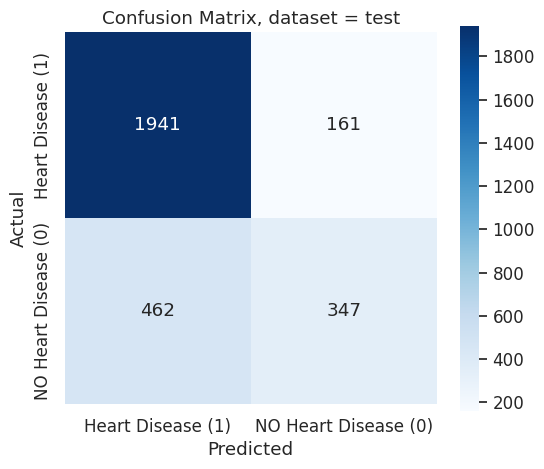

In [219]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

### B/ Train the whole model jointly (output layer + representation encoder)

In [224]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [275]:
for layer in encoder_model_question_1.layers:
    layer.trainable = True
print('CAREFUL!!!! Now the loaded layers are going to be retrained, and thus we need to reload the original model for the next question!')

CAREFUL!!!! Now the loaded layers are going to be retrained, and thus we need to reload the original model for the next question!


In [237]:
# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
B_MLP_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	B_MLP_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	B_MLP_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
B_MLP_from_enc_1.summary()

Model: "functional_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 40,250 (157.23 KB)

 Non-trainable params: 0 (0.00 B)

In [238]:
lib.custom_model_summary(B_MLP_from_enc_1)

Model: "functional_132"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     True
dense_33                            22560                 True
dropout_12                          0                     True
dense_34                            9680                  True
dropout_13                          0                     True
dense_35                            3240                  True
dense_39                            2624                  True
dense_40                            2080                  True
dense_41                            66                    True
Total params: 40250
Trainable params: 40250
Non-trainable params: 0


In [241]:
# Training
history = B_MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*8,
	epochs=5,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8351 - loss: 0.0458 - val_accuracy: 0.8527 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8483 - loss: 0.0436 - val_accuracy: 0.8622 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8515 - loss: 0.0409 - val_accuracy: 0.8849 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8726 - loss: 0.0374 - val_accuracy: 0.8935 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8873 - loss: 0.0338 - val_accuracy: 0.9068 - val_loss: 0.0296 - learning_rate: 0.0010


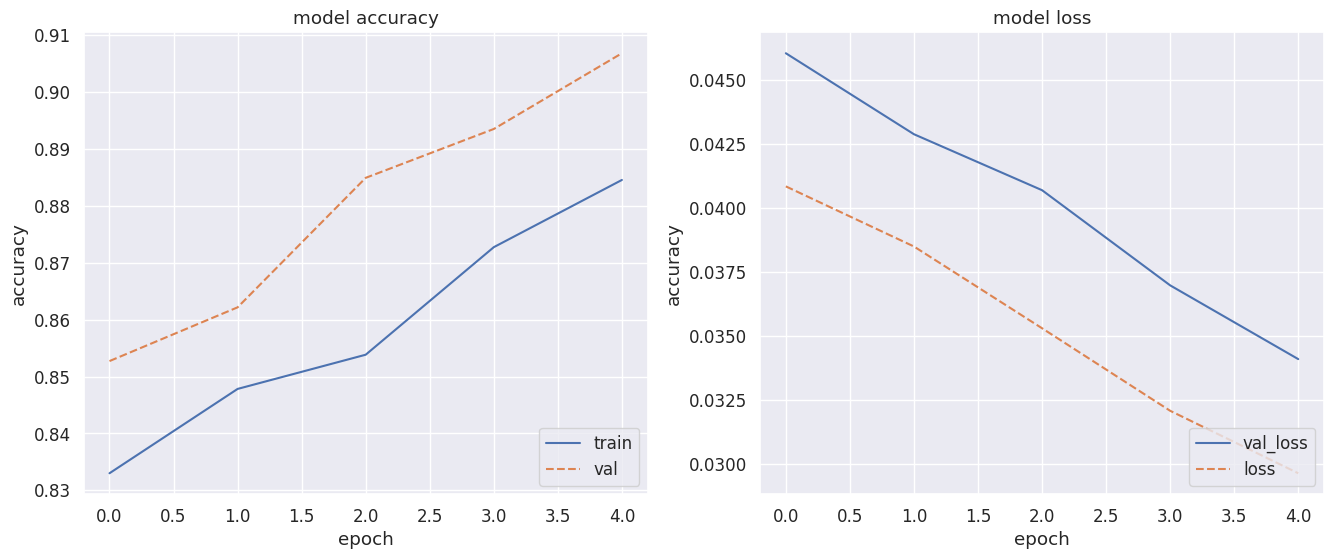

In [242]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [243]:
y_pred_proba = B_MLP_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [244]:
y_pred_class_df.value_counts()

1    2111
0     800
Name: count, dtype: int64

In [245]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [246]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,90.8%,88.4%,88.5%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

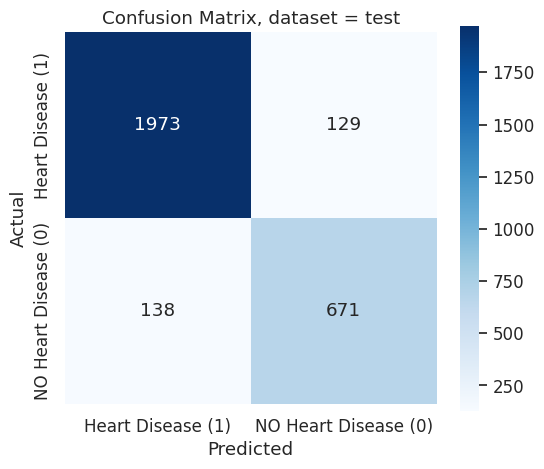

In [247]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

### C/ Two-stage training

#### First-Stage: only MLP Layers are unfrozen and trained

In [274]:
encoder_model_question_1 = load_model('model_log_v2.keras', custom_objects={'focal_loss_fixed': focal_loss})
print('Reloading the encoder model, as its layers have been retrained in the previous question.')

for layer in encoder_model_question_1.layers:
    layer.trainable = False

Reloading the encoder model, as its layers have been retrained in the previous question.


/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_siz
e=32

In [249]:
# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
C_MLP_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	C_MLP_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	C_MLP_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
C_MLP_from_enc_1.summary()

Model: "functional_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 4,770 (18.63 KB)

 Non-trainable params: 35,480 (138.59 KB)

In [250]:
lib.custom_model_summary(C_MLP_from_enc_1)

Model: "functional_136"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     False
dense_33                            22560                 False
dropout_12                          0                     False
dense_34                            9680                  False
dropout_13                          0                     False
dense_35                            3240                  False
dense_42                            2624                  True
dense_43                            2080                  True
dense_44                            66                    True
Total params: 40250
Trainable params: 4770
Non-trainable params: 35480


# Question 2 + ENCODER QUESTION 1: MLP Output layer

### A/ Train the output layer(s) only

In [ ]:
for layer in encoder_model_question_1.layers:
    layer.trainable = False

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [ ]:
# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
MLP_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	MLP_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	MLP_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
MLP_from_enc_1.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 4,770 (18.63 KB)

 Non-trainable params: 35,480 (138.59 KB)

In [ ]:
lib.custom_model_summary(MLP_from_enc_1)

Model: "functional_117"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     False
dense_33                            22560                 False
dropout_12                          0                     False
dense_34                            9680                  False
dropout_13                          0                     False
dense_35                            3240                  False
dense_27                            2624                  True
dense_28                            2080                  True
dense_29                            66                    True
Total params: 40250
Trainable params: 4770
Non-trainable params: 35480


In [ ]:
# Training
history = MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=20,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7646 - loss: 0.0598 - val_accuracy: 0.7930 - val_loss: 0.0573 - learning_rate: 2.7000e-05
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7630 - loss: 0.0601 - val_accuracy: 0.7939 - val_loss: 0.0573 - learning_rate: 2.7000e-05
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7655 - loss: 0.0602 - val_accuracy: 0.7909 - val_loss: 0.0572 - learning_rate: 2.7000e-05
Epoch 4/20
139/146 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7643 - loss: 0.0592
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7644 - loss: 0.0592 - val_accuracy: 0.7896 - val_loss: 0.0572 - learning_rate: 2.7000e-05
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7628 - loss: 0.0595 - val_accuracy: 0.7965 - val_loss: 0.0573 - learning_rate: 8.1000e-06
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.774

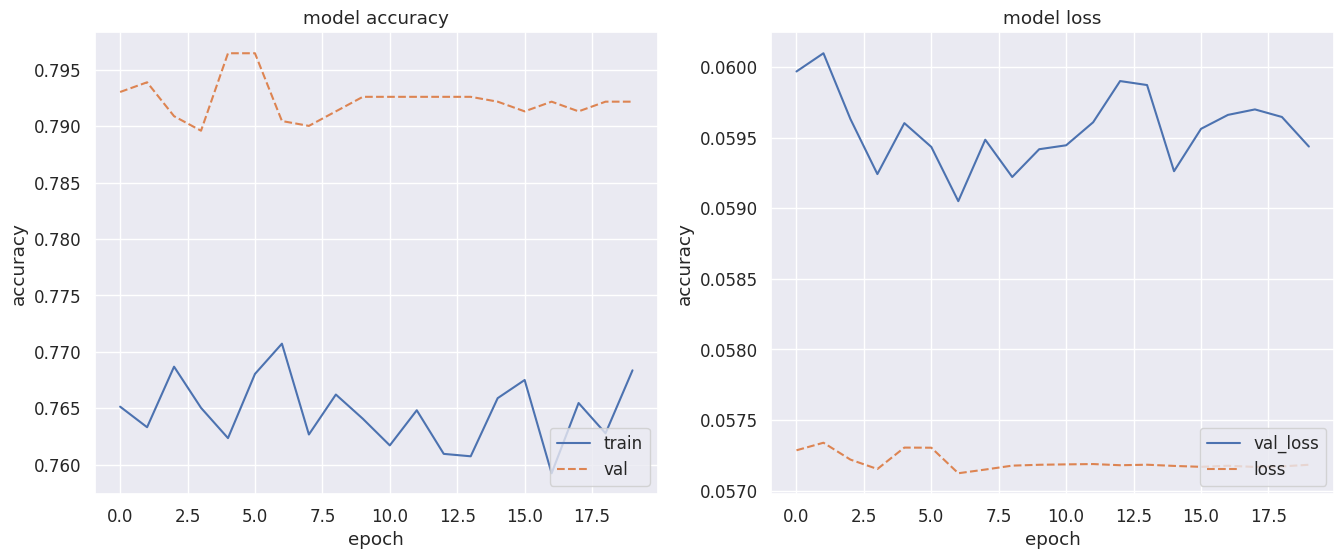

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [ ]:
y_pred_proba = MLP_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2403
0     508
Name: count, dtype: int64

In [ ]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,78.6%,67.6%,69.4%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

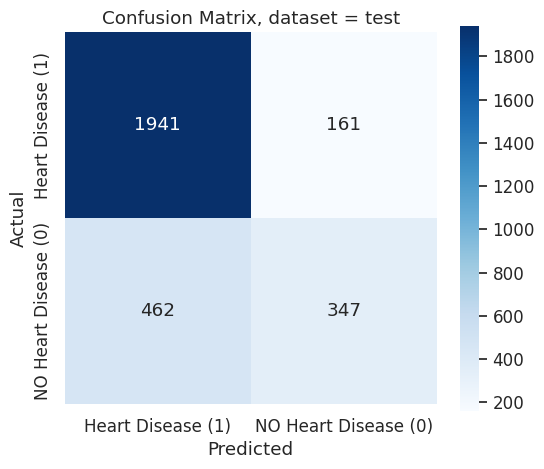

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

### B/ Train the whole model jointly (output layer + representation encoder)

In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [ ]:
for layer in encoder_model_question_1.layers:
    layer.trainable = True
print('CAREFUL!!!! Now the loaded layers are going to be retrained, and thus we need to reload the original model for the next question!')

CAREFUL!!!! Now the loaded layers are going to be retrained, and thus we need to reload the original model for the next question!


In [ ]:
# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
B_MLP_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	B_MLP_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	B_MLP_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
B_MLP_from_enc_1.summary()

Model: "functional_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 40,250 (157.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lib.custom_model_summary(B_MLP_from_enc_1)

Model: "functional_132"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     True
dense_33                            22560                 True
dropout_12                          0                     True
dense_34                            9680                  True
dropout_13                          0                     True
dense_35                            3240                  True
dense_39                            2624                  True
dense_40                            2080                  True
dense_41                            66                    True
Total params: 40250
Trainable params: 40250
Non-trainable params: 0


In [ ]:
# Training
history = B_MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*8,
	epochs=5,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8351 - loss: 0.0458 - val_accuracy: 0.8527 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8483 - loss: 0.0436 - val_accuracy: 0.8622 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8515 - loss: 0.0409 - val_accuracy: 0.8849 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8726 - loss: 0.0374 - val_accuracy: 0.8935 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8873 - loss: 0.0338 - val_accuracy: 0.9068 - val_loss: 0.0296 - learning_rate: 0.0010


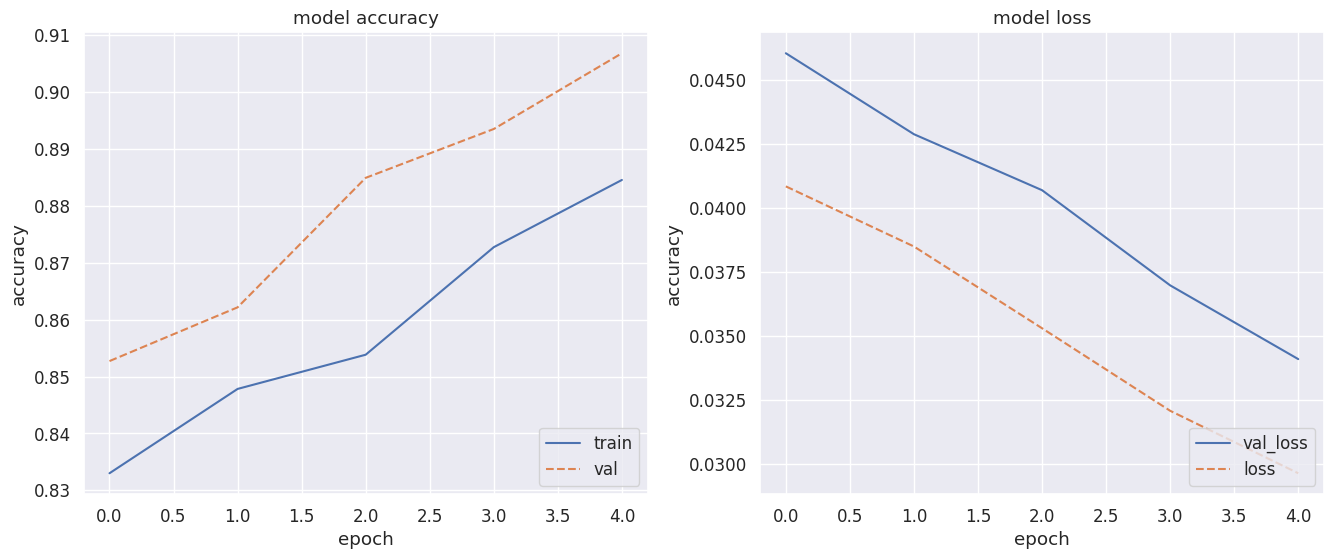

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [ ]:
y_pred_proba = B_MLP_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2111
0     800
Name: count, dtype: int64

In [ ]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,90.8%,88.4%,88.5%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

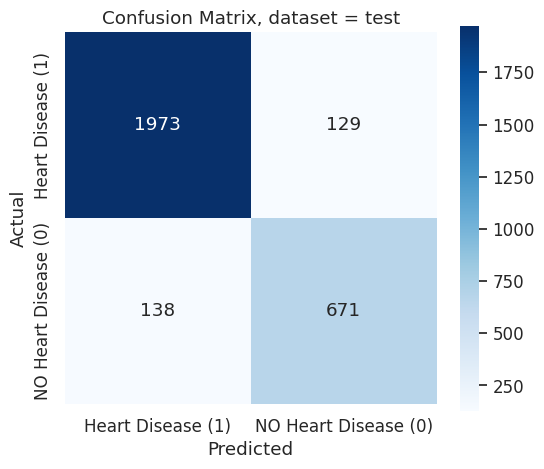

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

### C/ Two-stage training

#### First-Stage: only MLP Layers are unfrozen and trained

In [276]:
encoder_model_question_1 = load_model('model_log_v2.keras', custom_objects={'focal_loss_fixed': focal_loss})
print('CAREFUL! Reloading the encoder model, as its layers have been retrained in the previous question.')

for layer in encoder_model_question_1.layers:
    layer.trainable = False

CAREFUL! Reloading the encoder model, as its layers have been retrained in the previous question.


/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_siz
e=32

In [ ]:
# Get the input of the pretrained model
inputs = encoder_model_question_1.input[0]

# Get the output of the second to last layer
outputs = encoder_model_question_1.layers[-2].output

# Create a new model with the desired layers
encoder_model_no_head = Model(inputs=inputs, outputs=outputs)

# Create the new inputs from the no head pre-trained model
new_input = encoder_model_no_head.input

# Pass the encoder output to a new dense layer for logistic regression classification
x = encoder_model_no_head.output
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
C_MLP_from_enc_1 = Model(inputs=new_input, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	C_MLP_from_enc_1.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	C_MLP_from_enc_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
C_MLP_from_enc_1.summary()

Model: "functional_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 4,770 (18.63 KB)

 Non-trainable params: 35,480 (138.59 KB)

In [ ]:
custom_model_summary(C_MLP_from_enc_1)

Model: "functional_136"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     False
dense_33                            22560                 False
dropout_12                          0                     False
dense_34                            9680                  False
dropout_13                          0                     False
dense_35                            3240                  False
dense_42                            2624                  True
dense_43                            2080                  True
dense_44                            66                    True
Total params: 40250
Trainable params: 4770
Non-trainable params: 35480


In [ ]:
# Training
history = C_MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8493 - loss: 0.0443 - val_accuracy: 0.8987 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8877 - loss: 0.0332 - val_accuracy: 0.9038 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8959 - loss: 0.0326 - val_accuracy: 0.8892 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8862 - loss: 0.0336
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8862 - loss: 0.0336 - val_accuracy: 0.8948 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 5/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8915 - loss: 0.0328 - val_accuracy: 0.9098 - val_loss: 0.0279 - learning_rate: 3.0000e-04
Epoch 6/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9032 - loss: 0.0306 - val

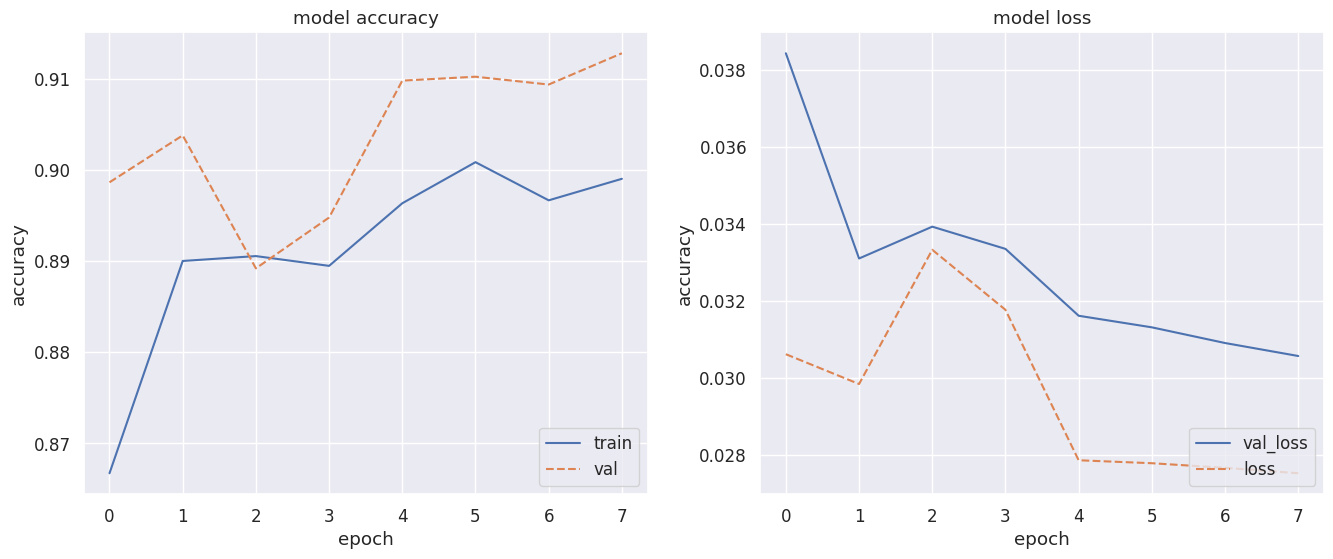

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Second-Stage: ALL Layers are unfrozen and trained

In [ ]:
for layer in C_MLP_from_enc_1.layers:
    layer.trainable = True

In [ ]:
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [ ]:
lib.custom_model_summary(C_MLP_from_enc_1)

Model: "functional_136"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     True
dense_33                            22560                 True
dropout_12                          0                     True
dense_34                            9680                  True
dropout_13                          0                     True
dense_35                            3240                  True
dense_42                            2624                  True
dense_43                            2080                  True
dense_44                            66                    True
Total params: 40250
Trainable params: 40250
Non-trainable params: 0


In [ ]:
# Training
history = C_MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9022 - loss: 0.0307 - val_accuracy: 0.9116 - val_loss: 0.0291 - learning_rate: 3.0000e-04
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8904 - loss: 0.0318 - val_accuracy: 0.9116 - val_loss: 0.0273 - learning_rate: 3.0000e-04
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8975 - loss: 0.0312 - val_accuracy: 0.9150 - val_loss: 0.0271 - learning_rate: 3.0000e-04
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9017 - loss: 0.0308 - val_accuracy: 0.9137 - val_loss: 0.0274 - learning_rate: 3.0000e-04
Epoch 5/8
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9030 - loss: 0.0300
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9029 - loss: 0.0301 - val_accuracy: 0.9103 - val_loss: 0.0271 - learning_rate: 3.0000e-04
Epoch 6/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8979 - l

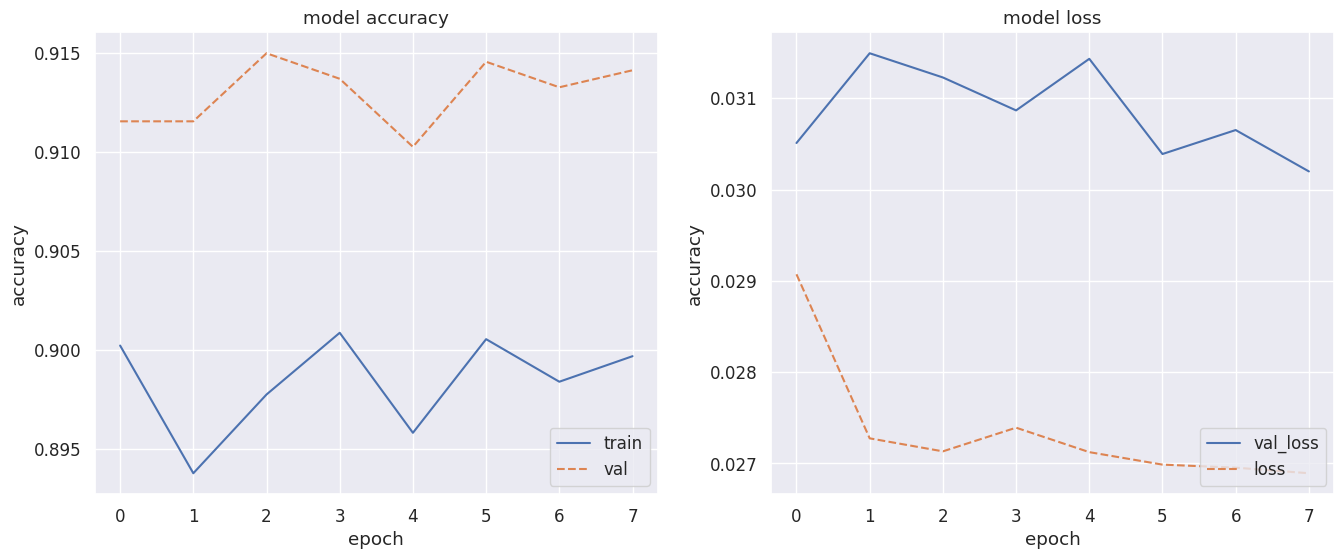

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [ ]:
y_pred_proba = C_MLP_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2072
0     839
Name: count, dtype: int64

In [ ]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,91.3%,89.7%,89.3%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

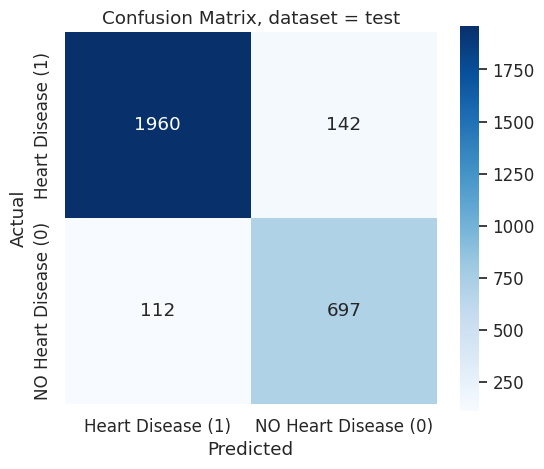

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

# fap

In [251]:
# Training
history = C_MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8493 - loss: 0.0443 - val_accuracy: 0.8987 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8877 - loss: 0.0332 - val_accuracy: 0.9038 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8959 - loss: 0.0326 - val_accuracy: 0.8892 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8862 - loss: 0.0336
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8862 - loss: 0.0336 - val_accuracy: 0.8948 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 5/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8915 - loss: 0.0328 - val_accuracy: 0.9098 - val_loss: 0.0279 - learning_rate: 3.0000e-04
Epoch 6/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9032 - loss: 0.0306 - val

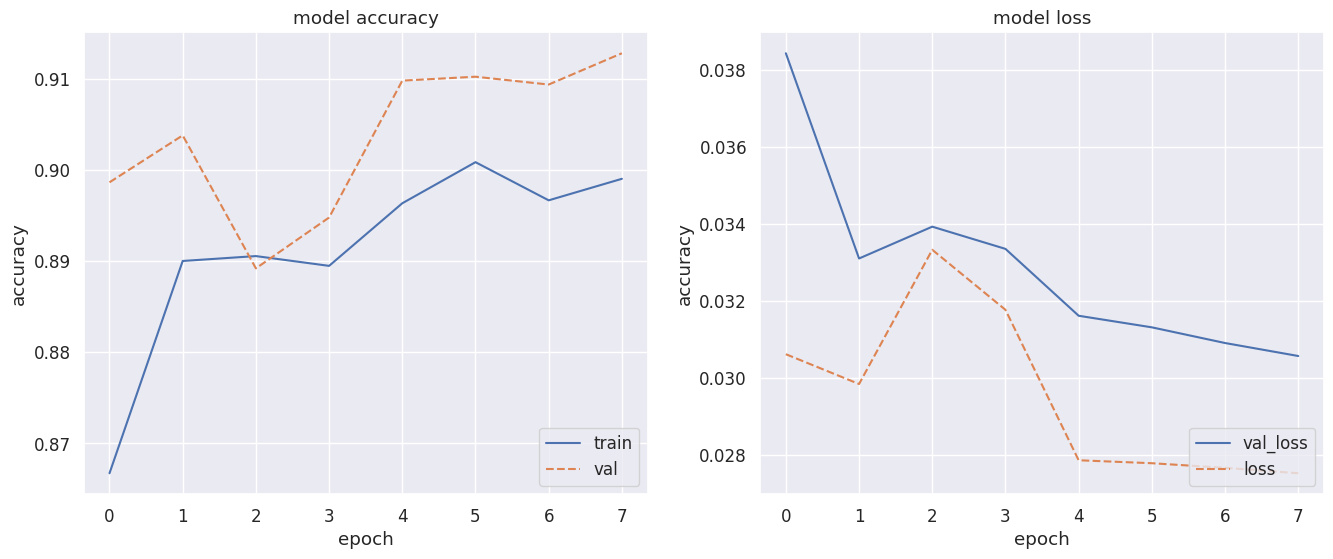

In [252]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Second-Stage: ALL Layers are unfrozen and trained

In [255]:
for layer in C_MLP_from_enc_1.layers:
    layer.trainable = True

In [ ]:
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [256]:
lib.custom_model_summary(C_MLP_from_enc_1)

Model: "functional_136"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     True
dense_33                            22560                 True
dropout_12                          0                     True
dense_34                            9680                  True
dropout_13                          0                     True
dense_35                            3240                  True
dense_42                            2624                  True
dense_43                            2080                  True
dense_44                            66                    True
Total params: 40250
Trainable params: 40250
Non-trainable params: 0


In [257]:
# Training
history = C_MLP_from_enc_1.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9022 - loss: 0.0307 - val_accuracy: 0.9116 - val_loss: 0.0291 - learning_rate: 3.0000e-04
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8904 - loss: 0.0318 - val_accuracy: 0.9116 - val_loss: 0.0273 - learning_rate: 3.0000e-04
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8975 - loss: 0.0312 - val_accuracy: 0.9150 - val_loss: 0.0271 - learning_rate: 3.0000e-04
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9017 - loss: 0.0308 - val_accuracy: 0.9137 - val_loss: 0.0274 - learning_rate: 3.0000e-04
Epoch 5/8
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9030 - loss: 0.0300
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9029 - loss: 0.0301 - val_accuracy: 0.9103 - val_loss: 0.0271 - learning_rate: 3.0000e-04
Epoch 6/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8979 - l

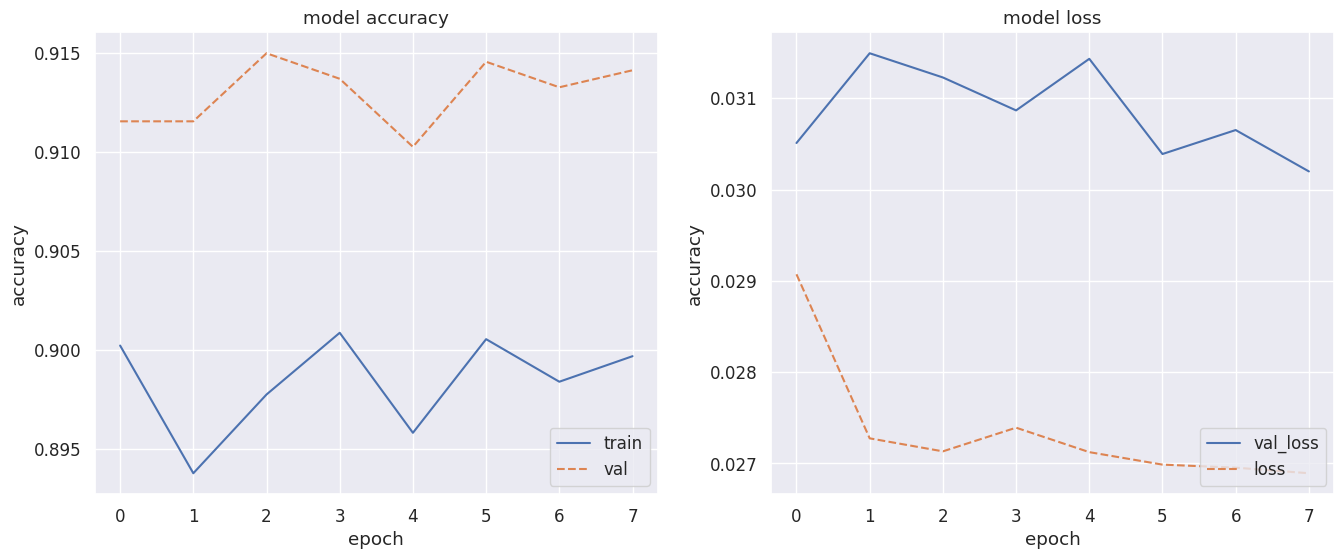

In [258]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [259]:
y_pred_proba = C_MLP_from_enc_1.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [264]:
y_pred_class_df.value_counts()

1    2072
0     839
Name: count, dtype: int64

In [265]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [266]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,91.3%,89.7%,89.3%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

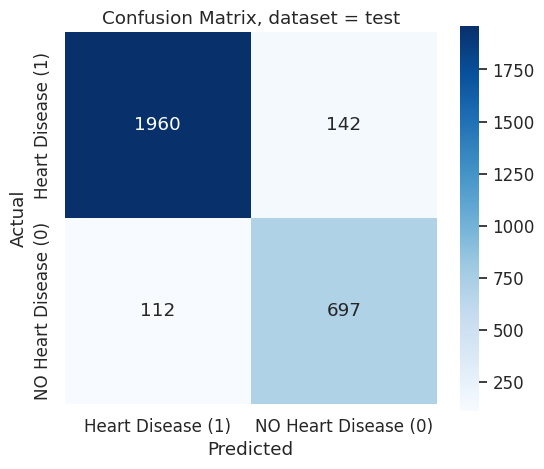

In [267]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

# Question 2 + ENCODER QUESTION 2: MLP Output layer

### A/ Train the output layer(s) only

In [ ]:
for layer in encoder_model_question_2.layers:
    layer.trainable = False

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [ ]:
# Get the input of the pretrained model
inputs = encoder_model_question_2.input[0]

# Get the output of the second to last layer
x = encoder_model_question_2.output[0]
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
# Activation layer
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
MLP_from_enc_2 = Model(inputs=inputs, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	MLP_from_enc_2.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	MLP_from_enc_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
MLP_from_enc_2.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 4,770 (18.63 KB)

 Non-trainable params: 35,480 (138.59 KB)

In [ ]:
lib.custom_model_summary(MLP_from_enc_2)

Model: "functional_117"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     False
dense_33                            22560                 False
dropout_12                          0                     False
dense_34                            9680                  False
dropout_13                          0                     False
dense_35                            3240                  False
dense_27                            2624                  True
dense_28                            2080                  True
dense_29                            66                    True
Total params: 40250
Trainable params: 4770
Non-trainable params: 35480


In [ ]:
# Training
history = MLP_from_enc_2.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=20,
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7646 - loss: 0.0598 - val_accuracy: 0.7930 - val_loss: 0.0573 - learning_rate: 2.7000e-05
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7630 - loss: 0.0601 - val_accuracy: 0.7939 - val_loss: 0.0573 - learning_rate: 2.7000e-05
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7655 - loss: 0.0602 - val_accuracy: 0.7909 - val_loss: 0.0572 - learning_rate: 2.7000e-05
Epoch 4/20
139/146 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7643 - loss: 0.0592
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7644 - loss: 0.0592 - val_accuracy: 0.7896 - val_loss: 0.0572 - learning_rate: 2.7000e-05
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7628 - loss: 0.0595 - val_accuracy: 0.7965 - val_loss: 0.0573 - learning_rate: 8.1000e-06
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.774

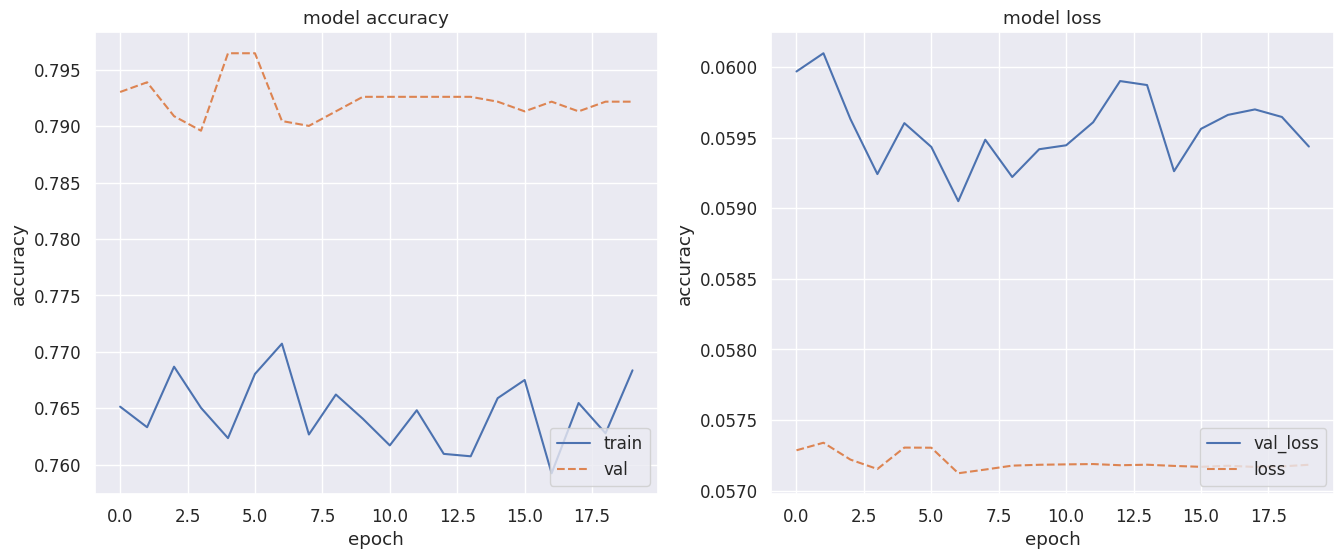

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [ ]:
y_pred_proba = MLP_from_enc_2.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2403
0     508
Name: count, dtype: int64

In [ ]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,78.6%,67.6%,69.4%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

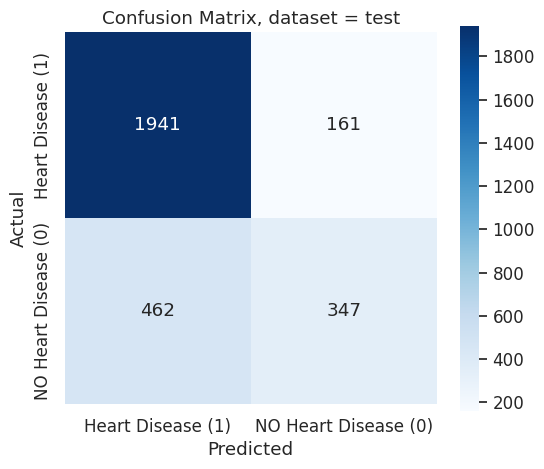

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

### B/ Train the whole model jointly (output layer + representation encoder)

In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [270]:
for layer in encoder_model_question_2.layers:
    layer.trainable = True
print('CAREFUL!!!! Now the loaded layers are going to be retrained, and thus we need to reload the original model for the next question!')

CAREFUL!!!! Now the loaded layers are going to be retrained, and thus we need to reload the original model for the next question!


In [ ]:
# Get the input of the pretrained model
inputs = encoder_model_question_2.input[0]

# Get the output of the second to last layer
x = encoder_model_question_2.output[0]
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
# Activation layer
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
B_MLP_from_enc_2 = Model(inputs=inputs, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	B_MLP_from_enc_2.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	B_MLP_from_enc_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
B_MLP_from_enc_2.summary()

Model: "functional_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 40,250 (157.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lib.custom_model_summary(B_MLP_from_enc_2)

Model: "functional_132"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     True
dense_33                            22560                 True
dropout_12                          0                     True
dense_34                            9680                  True
dropout_13                          0                     True
dense_35                            3240                  True
dense_39                            2624                  True
dense_40                            2080                  True
dense_41                            66                    True
Total params: 40250
Trainable params: 40250
Non-trainable params: 0


In [ ]:
# Training
history = B_MLP_from_enc_2.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*8,
	epochs=5,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8351 - loss: 0.0458 - val_accuracy: 0.8527 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8483 - loss: 0.0436 - val_accuracy: 0.8622 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8515 - loss: 0.0409 - val_accuracy: 0.8849 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8726 - loss: 0.0374 - val_accuracy: 0.8935 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8873 - loss: 0.0338 - val_accuracy: 0.9068 - val_loss: 0.0296 - learning_rate: 0.0010


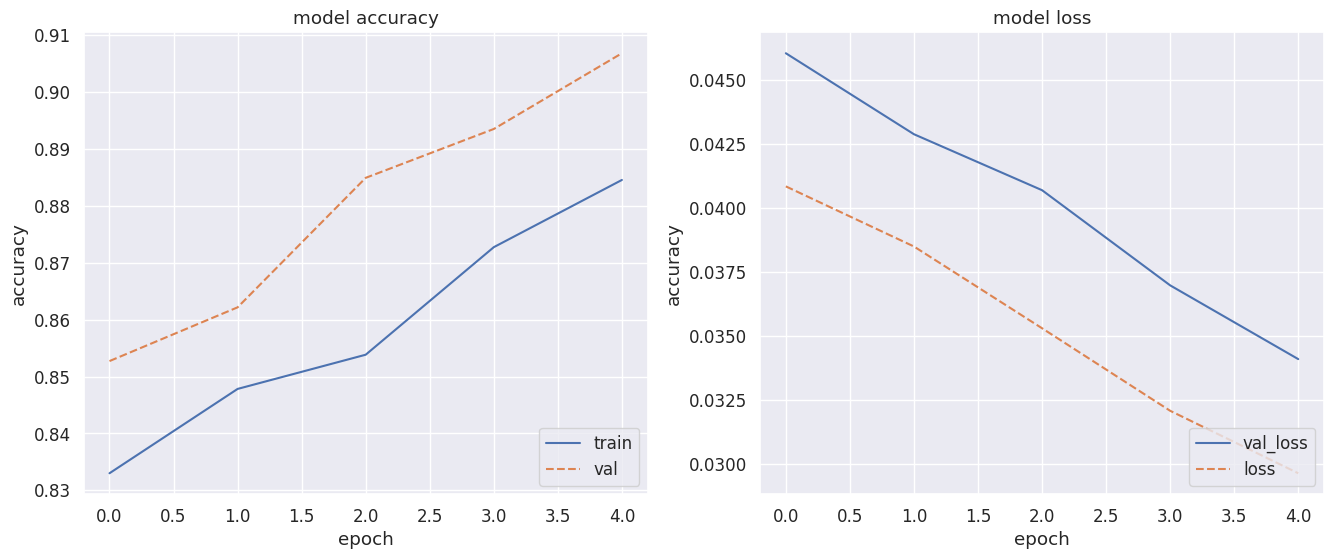

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [ ]:
y_pred_proba = B_MLP_from_enc_2.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2111
0     800
Name: count, dtype: int64

In [ ]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,90.8%,88.4%,88.5%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

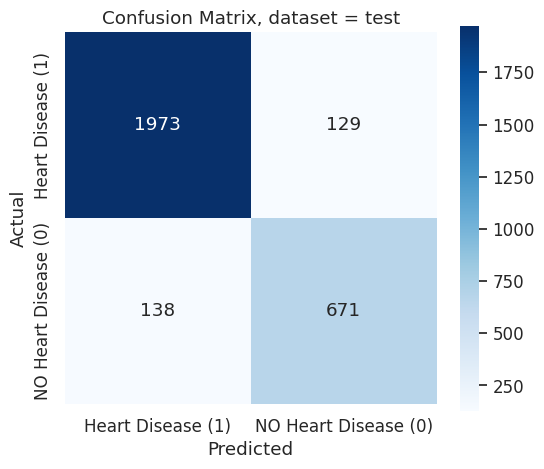

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

### C/ Two-stage training

#### First-Stage: only MLP Layers are unfrozen and trained

In [271]:
# Load the pre-trained encoder
encoder_model_question_2 = load_model('encoder_2.keras')
print('Reloading the encoder model, as its layers have been retrained in the previous question.')

Reloading the encoder model, as its layers have been retrained in the previous question.


In [ ]:
for layer in encoder_model_question_2.layers:
    layer.trainable = False

In [ ]:
# PARAMETERS
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_siz
e=32

In [ ]:
# Get the input of the pretrained model
inputs = encoder_model_question_2.input[0]

# Get the output of the second to last layer
x = encoder_model_question_2.output[0]
# 2 new Dense Layers (MLP)
x = Dense(n_neurons_MLP, activation='relu')(x)
x = Dense(int(n_neurons_MLP/2), activation='relu')(x)
# Activation layer
x = Dense(n_classes, activation='softmax')(x) # when n_classes=2, softmax and sigmoid are equivalent

# Create the new model
C_MLP_from_enc_2 = Model(inputs=inputs, outputs=x)

# Compile the new model
if use_sgd_opt:
	opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
elif use_rms_opt:
	opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
else:
	opt = Adam(learning_rate=learning_rate)

if use_focal:
	C_MLP_from_enc_2.compile(loss=focal_loss(), optimizer=opt, metrics=['accuracy'])
	# model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
else:
	C_MLP_from_enc_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Summary of the new model
C_MLP_from_enc_2.summary()

Model: "functional_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 120)            │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 80)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,250 (157.23 KB)

 Trainable params: 4,770 (18.63 KB)

 Non-trainable params: 35,480 (138.59 KB)

In [ ]:
lib.custom_model_summary(C_MLP_from_enc_2)

Model: "functional_136"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     False
dense_33                            22560                 False
dropout_12                          0                     False
dense_34                            9680                  False
dropout_13                          0                     False
dense_35                            3240                  False
dense_42                            2624                  True
dense_43                            2080                  True
dense_44                            66                    True
Total params: 40250
Trainable params: 4770
Non-trainable params: 35480


In [ ]:
# Training
history = C_MLP_from_enc_2.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8493 - loss: 0.0443 - val_accuracy: 0.8987 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8877 - loss: 0.0332 - val_accuracy: 0.9038 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8959 - loss: 0.0326 - val_accuracy: 0.8892 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8862 - loss: 0.0336
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8862 - loss: 0.0336 - val_accuracy: 0.8948 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 5/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8915 - loss: 0.0328 - val_accuracy: 0.9098 - val_loss: 0.0279 - learning_rate: 3.0000e-04
Epoch 6/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9032 - loss: 0.0306 - val

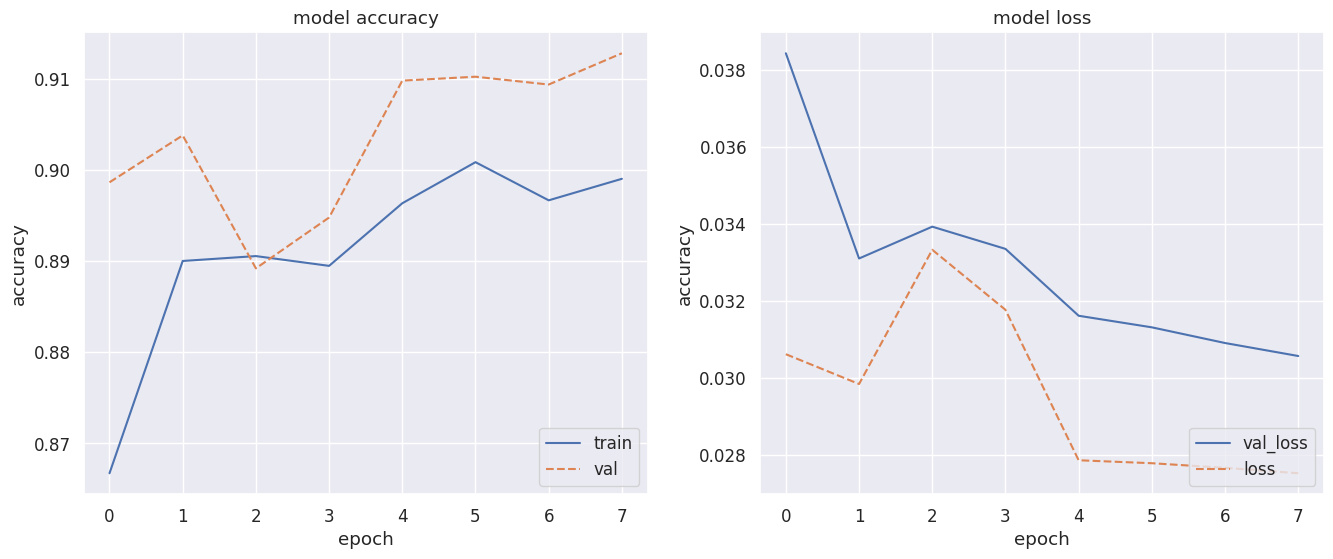

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Second-Stage: ALL Layers are unfrozen and trained

In [ ]:
for layer in C_MLP_from_enc_2.layers:
    layer.trainable = True

In [ ]:
n_neurons_MLP = 64
learning_rate=0.001
use_focal=True
clipnorm=0.5
use_sgd_opt=False
use_rms_opt=False
batch_size=32

In [ ]:
lib.custom_model_summary(C_MLP_from_enc_2)

Model: "functional_136"
Layer (type)                           Param #          Trainable
input_layer_14                      0                     True
dense_33                            22560                 True
dropout_12                          0                     True
dense_34                            9680                  True
dropout_13                          0                     True
dense_35                            3240                  True
dense_42                            2624                  True
dense_43                            2080                  True
dense_44                            66                    True
Total params: 40250
Trainable params: 40250
Non-trainable params: 0


In [ ]:
# Training
history = C_MLP_from_enc_2.fit(
	x_train_0,
	y_train_0,
	batch_size=batch_size*2,
	epochs=8,
	# validation_data=(x_test_0, y_test_0),
	validation_split=0.2,
	callbacks = [learning_rate_reduction],
	)

Epoch 1/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9022 - loss: 0.0307 - val_accuracy: 0.9116 - val_loss: 0.0291 - learning_rate: 3.0000e-04
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8904 - loss: 0.0318 - val_accuracy: 0.9116 - val_loss: 0.0273 - learning_rate: 3.0000e-04
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8975 - loss: 0.0312 - val_accuracy: 0.9150 - val_loss: 0.0271 - learning_rate: 3.0000e-04
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9017 - loss: 0.0308 - val_accuracy: 0.9137 - val_loss: 0.0274 - learning_rate: 3.0000e-04
Epoch 5/8
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9030 - loss: 0.0300
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9029 - loss: 0.0301 - val_accuracy: 0.9103 - val_loss: 0.0271 - learning_rate: 3.0000e-04
Epoch 6/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8979 - l

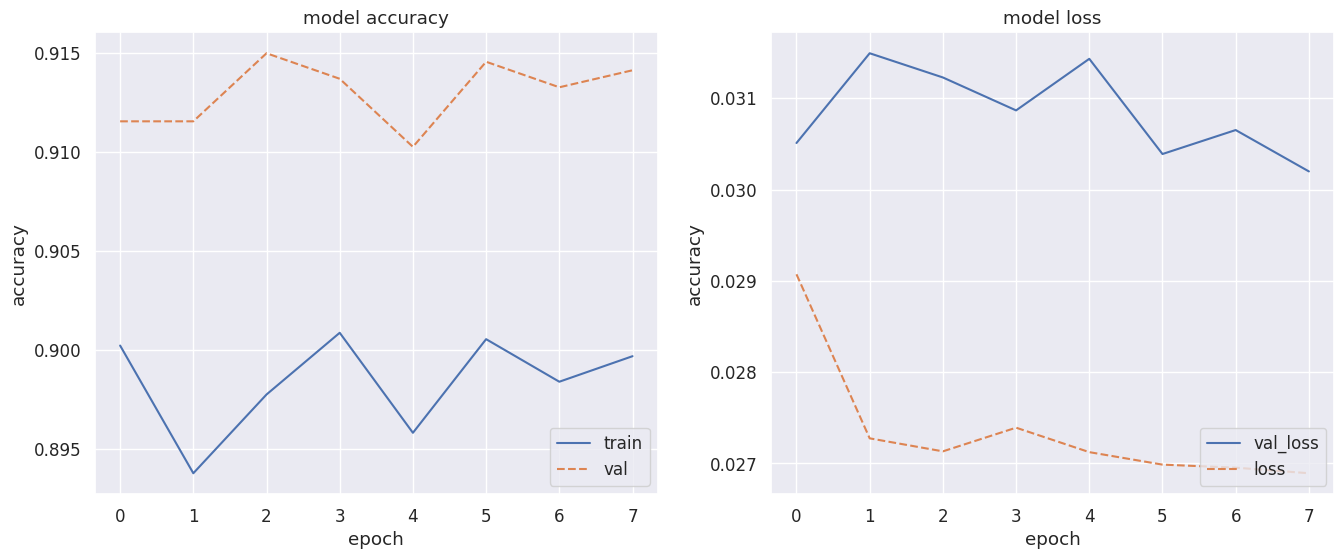

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

#### Evaluation

In [ ]:
y_pred_proba = C_MLP_from_enc_2.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
y_pred_class_df.value_counts()

1    2072
0     839
Name: count, dtype: int64

In [ ]:
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,91.3%,89.7%,89.3%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

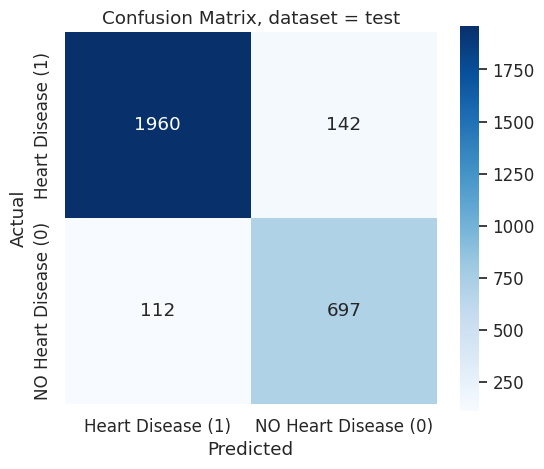

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

# fap